<a href="https://colab.research.google.com/github/Nada-Elghaweet/Ai-safety-system/blob/Randomforest_IMGS/RandomForestModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:

from google.colab import files
import zipfile
import os

uploaded = files.upload()
zip_name = 'VIOLENCE VS NON_VIOLENCE.zip'
extract_path = 'dataset'

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path))

Saving VIOLENCE VS NON_VIOLENCE.zip to VIOLENCE VS NON_VIOLENCE (3).zip
['VIOLENCE VS NON_VIOLENCE']


In [61]:
import glob
import os

DATA_DIR = 'dataset/VIOLENCE VS NON_VIOLENCE'
CLASSES = sorted(os.listdir(os.path.join(DATA_DIR, 'train')))
print("Classes:", CLASSES)

def get_image_paths_labels(split):
    X_paths, y_labels = [], []
    for label, cls in enumerate(CLASSES):
        folder = os.path.join(DATA_DIR, split, cls)
        for img_path in glob.glob(os.path.join(folder, '*')):
            X_paths.append(img_path)
            y_labels.append(label)
    return X_paths, y_labels

X_train_paths, y_train = get_image_paths_labels('train')
X_val_paths, y_val = get_image_paths_labels('val')
X_test_paths, y_test = get_image_paths_labels('test')

print(f"Train: {len(X_train_paths)}, Val: {len(X_val_paths)}, Test: {len(X_test_paths)}")

Classes: ['non_violence', 'violence']
Train: 700, Val: 156, Test: 117


In [62]:
import cv2
import numpy as np
from skimage.feature import hog

def extract_features_with_labels(img_paths, labels):
    features, new_labels = [], []

    for path, label in zip(img_paths, labels):
        img = cv2.imread(path)
        img = cv2.resize(img, (64, 64))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)

        hist = cv2.calcHist([img], [0, 1, 2], None,
                            [8, 8, 8],
                            [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        features.append(np.hstack([hog_feat, hist]))
        new_labels.append(label)

        # Horizontal flip augmentation
        img_flip = cv2.flip(img, 1)
        gray_flip = cv2.cvtColor(img_flip, cv2.COLOR_BGR2GRAY)
        hog_flip = hog(gray_flip, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)

        hist_flip = cv2.calcHist([img_flip], [0, 1, 2], None,
                                 [8, 8, 8],
                                 [0, 256, 0, 256, 0, 256])
        hist_flip = cv2.normalize(hist_flip, hist_flip).flatten()

        features.append(np.hstack([hog_flip, hist_flip]))
        new_labels.append(label)

    return np.array(features), np.array(new_labels)

def extract_features(img_paths):
    features = []
    for path in img_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (64, 64))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)

        hist = cv2.calcHist([img], [0, 1, 2], None,
                            [8, 8, 8],
                            [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        features.append(np.hstack([hog_feat, hist]))

    return np.array(features)

In [63]:
X_train_features, y_train_aug = extract_features_with_labels(
    X_train_paths, y_train)

X_val_features = extract_features(X_val_paths)
X_test_features = extract_features(X_test_paths)

print("Feature Shapes:")
print("Train:", X_train_features.shape)
print("Val:", X_val_features.shape)
print("Test:", X_test_features.shape)

Feature Shapes:
Train: (1400, 2276)
Val: (156, 2276)
Test: (117, 2276)


In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_features, y_train_aug)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=4,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [66]:
val_pred = rf.predict(X_val_features)
print("Train Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred, target_names=CLASSES))

test_pred = rf.predict(X_test_features)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred, target_names=CLASSES))


Train Accuracy: 0.717948717948718
              precision    recall  f1-score   support

non_violence       0.66      0.90      0.76        78
    violence       0.84      0.54      0.66        78

    accuracy                           0.72       156
   macro avg       0.75      0.72      0.71       156
weighted avg       0.75      0.72      0.71       156

Test Accuracy: 0.6153846153846154
              precision    recall  f1-score   support

non_violence       0.31      1.00      0.47        20
    violence       1.00      0.54      0.70        97

    accuracy                           0.62       117
   macro avg       0.65      0.77      0.58       117
weighted avg       0.88      0.62      0.66       117



In [46]:
val_pred = rf.predict(X_val_features)
print("train Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred, target_names=CLASSES))

test_pred = rf.predict(X_test_features)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred, target_names=CLASSES))

train Accuracy: 0.717948717948718
              precision    recall  f1-score   support

non_violence       0.66      0.90      0.76        78
    violence       0.84      0.54      0.66        78

    accuracy                           0.72       156
   macro avg       0.75      0.72      0.71       156
weighted avg       0.75      0.72      0.71       156

Test Accuracy: 0.6153846153846154
              precision    recall  f1-score   support

non_violence       0.31      1.00      0.47        20
    violence       1.00      0.54      0.70        97

    accuracy                           0.62       117
   macro avg       0.65      0.77      0.58       117
weighted avg       0.88      0.62      0.66       117



In [67]:
pred_probs = rf.predict_proba(X_test_features)[:, 1]

pred_labels = []
for prob in pred_probs.flatten():
    if prob > 0.5:
        pred_labels.append("VIOLENCE")
    else:
        pred_labels.append("NON VIOLENCE")

import pandas as pd

filenames = X_test_paths

results = pd.DataFrame({
    'filename': filenames,
    'prediction': pred_labels
})

results.to_csv("random_forest_test_predictions.csv", index=False)
print("Predictions saved!")

for i in range(5):
    print(f"{filenames[i]} --> {pred_labels[i]}")

Predictions saved!
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (440).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (444).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (407).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (299).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (220).jpg --> NON VIOLENCE


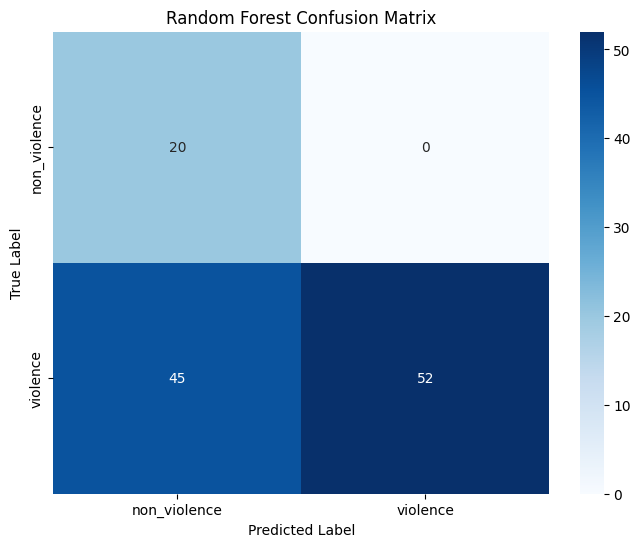

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES,
            yticklabels=CLASSES)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [75]:
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np

n_estimators_range = [50, 100, 200, 300, 400, 500]

train_acc, val_acc = [], []
train_loss, val_loss = [], []

rf_curve = RandomForestClassifier(
    n_estimators=0,  # start from 0
    warm_start=True,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

for n in n_estimators_range:
    rf_curve.n_estimators = n
    rf_curve.fit(X_train_features, y_train_aug)

    train_pred = rf_curve.predict(X_train_features)
    val_pred = rf_curve.predict(X_val_features)

    train_proba = rf_curve.predict_proba(X_train_features)
    val_proba = rf_curve.predict_proba(X_val_features)

    train_acc.append(accuracy_score(y_train_aug, train_pred))
    val_acc.append(accuracy_score(y_val, val_pred))

    train_loss.append(log_loss(y_train_aug, train_proba))
    val_loss.append(log_loss(y_val, val_proba))

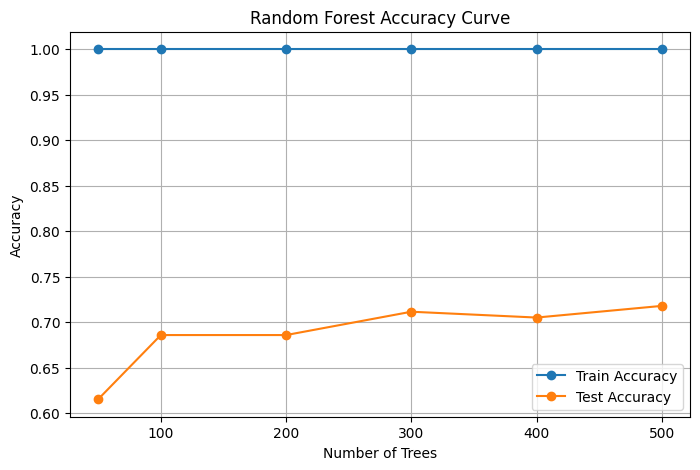

In [77]:
plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, train_acc, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, val_acc, marker='o', label='Test Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()


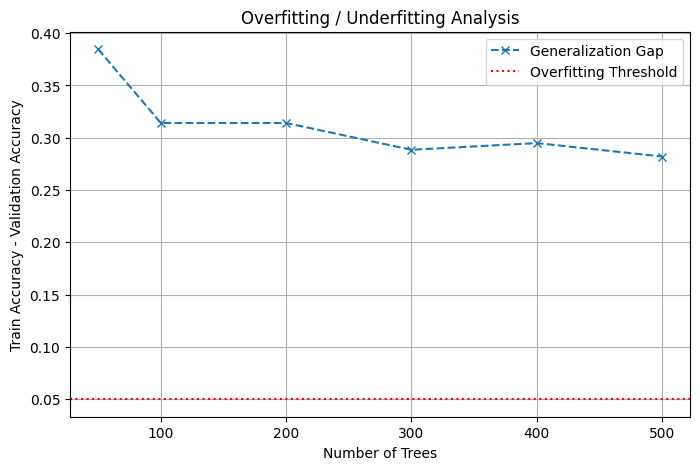

In [78]:
gap = np.array(train_acc) - np.array(val_acc)

plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, gap, marker='x', linestyle='--', label='Generalization Gap')
plt.axhline(0.05, linestyle=':', color='red', label='Overfitting Threshold')
plt.xlabel('Number of Trees')
plt.ylabel('Train Accuracy - Validation Accuracy')
plt.title('Overfitting / Underfitting Analysis')
plt.legend()
plt.grid(True)
plt.show()


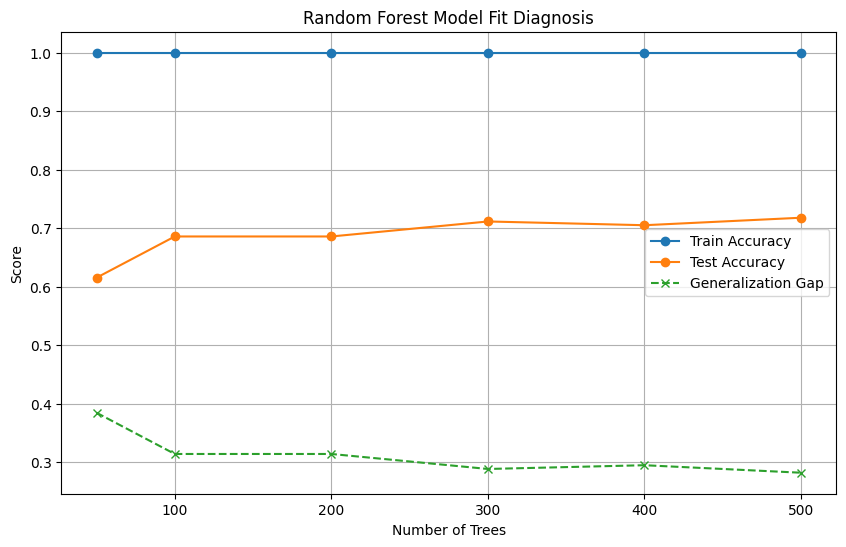

In [79]:
plt.figure(figsize=(10,6))
plt.plot(n_estimators_range, train_acc, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, val_acc, marker='o', label='Test Accuracy')
plt.plot(n_estimators_range, gap, marker='x', linestyle='--', label='Generalization Gap')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Random Forest Model Fit Diagnosis')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

from google.colab import files
import zipfile
import os

uploaded = files.upload()
zip_name = 'VIOLENCE VS NON_VIOLENCE.zip'
extract_path = 'dataset'

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path))

Saving VIOLENCE VS NON_VIOLENCE.zip to VIOLENCE VS NON_VIOLENCE (3).zip
['VIOLENCE VS NON_VIOLENCE']


In [ ]:
import glob
import os

DATA_DIR = 'dataset/VIOLENCE VS NON_VIOLENCE'
CLASSES = sorted(os.listdir(os.path.join(DATA_DIR, 'train')))
print("Classes:", CLASSES)

def get_image_paths_labels(split):
    X_paths, y_labels = [], []
    for label, cls in enumerate(CLASSES):
        folder = os.path.join(DATA_DIR, split, cls)
        for img_path in glob.glob(os.path.join(folder, '*')):
            X_paths.append(img_path)
            y_labels.append(label)
    return X_paths, y_labels

X_train_paths, y_train = get_image_paths_labels('train')
X_val_paths, y_val = get_image_paths_labels('val')
X_test_paths, y_test = get_image_paths_labels('test')

print(f"Train: {len(X_train_paths)}, Val: {len(X_val_paths)}, Test: {len(X_test_paths)}")

Classes: ['non_violence', 'violence']
Train: 700, Val: 156, Test: 117


In [ ]:
import cv2
import numpy as np
from skimage.feature import hog

def extract_features_with_labels(img_paths, labels):
    features, new_labels = [], []

    for path, label in zip(img_paths, labels):
        img = cv2.imread(path)
        img = cv2.resize(img, (64, 64))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)

        hist = cv2.calcHist([img], [0, 1, 2], None,
                            [8, 8, 8],
                            [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        features.append(np.hstack([hog_feat, hist]))
        new_labels.append(label)

        # Horizontal flip augmentation
        img_flip = cv2.flip(img, 1)
        gray_flip = cv2.cvtColor(img_flip, cv2.COLOR_BGR2GRAY)
        hog_flip = hog(gray_flip, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)

        hist_flip = cv2.calcHist([img_flip], [0, 1, 2], None,
                                 [8, 8, 8],
                                 [0, 256, 0, 256, 0, 256])
        hist_flip = cv2.normalize(hist_flip, hist_flip).flatten()

        features.append(np.hstack([hog_flip, hist_flip]))
        new_labels.append(label)

    return np.array(features), np.array(new_labels)

def extract_features(img_paths):
    features = []
    for path in img_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (64, 64))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)

        hist = cv2.calcHist([img], [0, 1, 2], None,
                            [8, 8, 8],
                            [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        features.append(np.hstack([hog_feat, hist]))

    return np.array(features)

In [ ]:
X_train_features, y_train_aug = extract_features_with_labels(
    X_train_paths, y_train)

X_val_features = extract_features(X_val_paths)
X_test_features = extract_features(X_test_paths)

print("Feature Shapes:")
print("Train:", X_train_features.shape)
print("Val:", X_val_features.shape)
print("Test:", X_test_features.shape)

Feature Shapes:
Train: (1400, 2276)
Val: (156, 2276)
Test: (117, 2276)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_features, y_train_aug)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=4,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
val_pred = rf.predict(X_val_features)
print("Train Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred, target_names=CLASSES))

test_pred = rf.predict(X_test_features)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred, target_names=CLASSES))


Train Accuracy: 0.717948717948718
              precision    recall  f1-score   support

non_violence       0.66      0.90      0.76        78
    violence       0.84      0.54      0.66        78

    accuracy                           0.72       156
   macro avg       0.75      0.72      0.71       156
weighted avg       0.75      0.72      0.71       156

Test Accuracy: 0.6153846153846154
              precision    recall  f1-score   support

non_violence       0.31      1.00      0.47        20
    violence       1.00      0.54      0.70        97

    accuracy                           0.62       117
   macro avg       0.65      0.77      0.58       117
weighted avg       0.88      0.62      0.66       117



In [ ]:
val_pred = rf.predict(X_val_features)
print("train Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred, target_names=CLASSES))

test_pred = rf.predict(X_test_features)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred, target_names=CLASSES))

train Accuracy: 0.717948717948718
              precision    recall  f1-score   support

non_violence       0.66      0.90      0.76        78
    violence       0.84      0.54      0.66        78

    accuracy                           0.72       156
   macro avg       0.75      0.72      0.71       156
weighted avg       0.75      0.72      0.71       156

Test Accuracy: 0.6153846153846154
              precision    recall  f1-score   support

non_violence       0.31      1.00      0.47        20
    violence       1.00      0.54      0.70        97

    accuracy                           0.62       117
   macro avg       0.65      0.77      0.58       117
weighted avg       0.88      0.62      0.66       117



In [ ]:
pred_probs = rf.predict_proba(X_test_features)[:, 1]

pred_labels = []
for prob in pred_probs.flatten():
    if prob > 0.5:
        pred_labels.append("VIOLENCE")
    else:
        pred_labels.append("NON VIOLENCE")

import pandas as pd

filenames = X_test_paths

results = pd.DataFrame({
    'filename': filenames,
    'prediction': pred_labels
})

results.to_csv("random_forest_test_predictions.csv", index=False)
print("Predictions saved!")

for i in range(5):
    print(f"{filenames[i]} --> {pred_labels[i]}")

Predictions saved!
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (440).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (444).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (407).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (299).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (220).jpg --> NON VIOLENCE


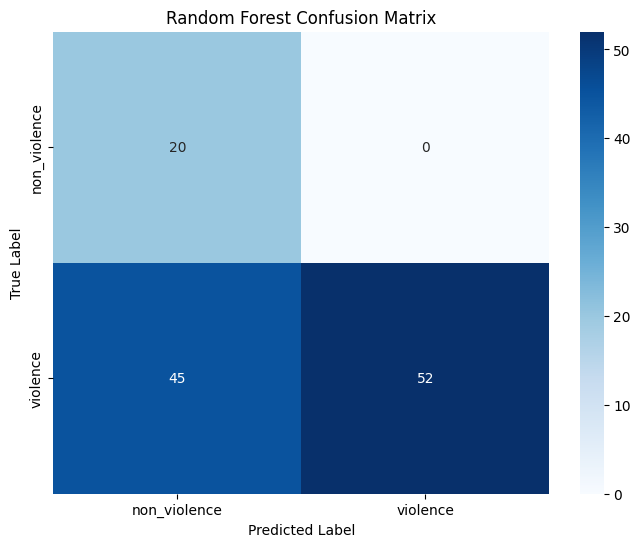

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES,
            yticklabels=CLASSES)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np

n_estimators_range = [50, 100, 200, 300, 400, 500]

train_acc, val_acc = [], []
train_loss, val_loss = [], []

rf_curve = RandomForestClassifier(
    n_estimators=0,  # start from 0
    warm_start=True,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

for n in n_estimators_range:
    rf_curve.n_estimators = n
    rf_curve.fit(X_train_features, y_train_aug)

    train_pred = rf_curve.predict(X_train_features)
    val_pred = rf_curve.predict(X_val_features)

    train_proba = rf_curve.predict_proba(X_train_features)
    val_proba = rf_curve.predict_proba(X_val_features)

    train_acc.append(accuracy_score(y_train_aug, train_pred))
    val_acc.append(accuracy_score(y_val, val_pred))

    train_loss.append(log_loss(y_train_aug, train_proba))
    val_loss.append(log_loss(y_val, val_proba))

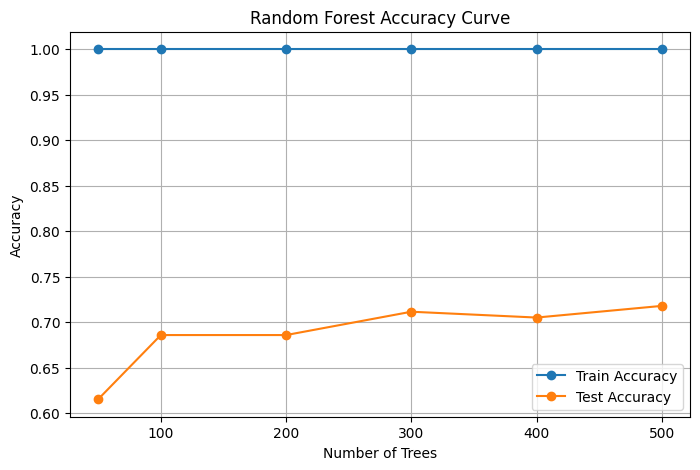

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, train_acc, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, val_acc, marker='o', label='Test Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()


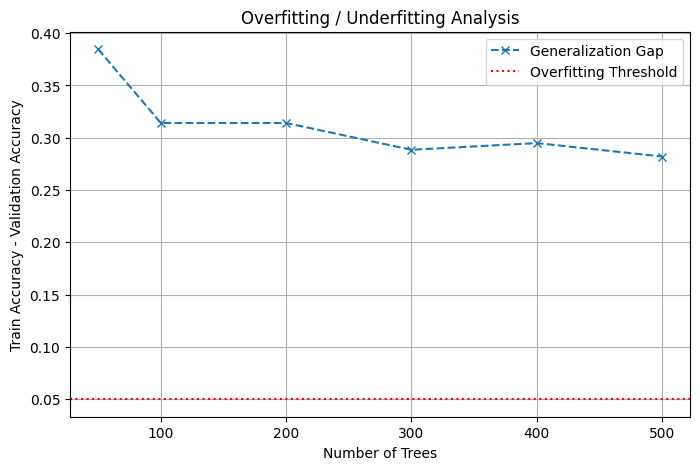

In [ ]:
gap = np.array(train_acc) - np.array(val_acc)

plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, gap, marker='x', linestyle='--', label='Generalization Gap')
plt.axhline(0.05, linestyle=':', color='red', label='Overfitting Threshold')
plt.xlabel('Number of Trees')
plt.ylabel('Train Accuracy - Validation Accuracy')
plt.title('Overfitting / Underfitting Analysis')
plt.legend()
plt.grid(True)
plt.show()


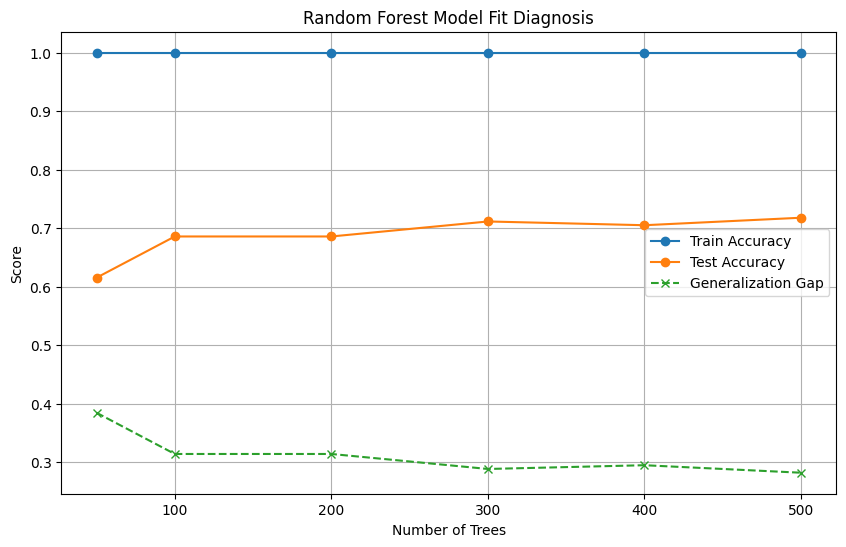

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(n_estimators_range, train_acc, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, val_acc, marker='o', label='Test Accuracy')
plt.plot(n_estimators_range, gap, marker='x', linestyle='--', label='Generalization Gap')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Random Forest Model Fit Diagnosis')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

from google.colab import files
import zipfile
import os

uploaded = files.upload()
zip_name = 'VIOLENCE VS NON_VIOLENCE.zip'
extract_path = 'dataset'

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path))

Saving VIOLENCE VS NON_VIOLENCE.zip to VIOLENCE VS NON_VIOLENCE (3).zip
['VIOLENCE VS NON_VIOLENCE']


In [ ]:
import glob
import os

DATA_DIR = 'dataset/VIOLENCE VS NON_VIOLENCE'
CLASSES = sorted(os.listdir(os.path.join(DATA_DIR, 'train')))
print("Classes:", CLASSES)

def get_image_paths_labels(split):
    X_paths, y_labels = [], []
    for label, cls in enumerate(CLASSES):
        folder = os.path.join(DATA_DIR, split, cls)
        for img_path in glob.glob(os.path.join(folder, '*')):
            X_paths.append(img_path)
            y_labels.append(label)
    return X_paths, y_labels

X_train_paths, y_train = get_image_paths_labels('train')
X_val_paths, y_val = get_image_paths_labels('val')
X_test_paths, y_test = get_image_paths_labels('test')

print(f"Train: {len(X_train_paths)}, Val: {len(X_val_paths)}, Test: {len(X_test_paths)}")

Classes: ['non_violence', 'violence']
Train: 700, Val: 156, Test: 117


In [ ]:
import cv2
import numpy as np
from skimage.feature import hog

def extract_features_with_labels(img_paths, labels):
    features, new_labels = [], []

    for path, label in zip(img_paths, labels):
        img = cv2.imread(path)
        img = cv2.resize(img, (64, 64))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)

        hist = cv2.calcHist([img], [0, 1, 2], None,
                            [8, 8, 8],
                            [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        features.append(np.hstack([hog_feat, hist]))
        new_labels.append(label)

        # Horizontal flip augmentation
        img_flip = cv2.flip(img, 1)
        gray_flip = cv2.cvtColor(img_flip, cv2.COLOR_BGR2GRAY)
        hog_flip = hog(gray_flip, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)

        hist_flip = cv2.calcHist([img_flip], [0, 1, 2], None,
                                 [8, 8, 8],
                                 [0, 256, 0, 256, 0, 256])
        hist_flip = cv2.normalize(hist_flip, hist_flip).flatten()

        features.append(np.hstack([hog_flip, hist_flip]))
        new_labels.append(label)

    return np.array(features), np.array(new_labels)

def extract_features(img_paths):
    features = []
    for path in img_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (64, 64))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)

        hist = cv2.calcHist([img], [0, 1, 2], None,
                            [8, 8, 8],
                            [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        features.append(np.hstack([hog_feat, hist]))

    return np.array(features)

In [ ]:
X_train_features, y_train_aug = extract_features_with_labels(
    X_train_paths, y_train)

X_val_features = extract_features(X_val_paths)
X_test_features = extract_features(X_test_paths)

print("Feature Shapes:")
print("Train:", X_train_features.shape)
print("Val:", X_val_features.shape)
print("Test:", X_test_features.shape)

Feature Shapes:
Train: (1400, 2276)
Val: (156, 2276)
Test: (117, 2276)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_features, y_train_aug)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=4,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
val_pred = rf.predict(X_val_features)
print("Train Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred, target_names=CLASSES))

test_pred = rf.predict(X_test_features)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred, target_names=CLASSES))


Train Accuracy: 0.717948717948718
              precision    recall  f1-score   support

non_violence       0.66      0.90      0.76        78
    violence       0.84      0.54      0.66        78

    accuracy                           0.72       156
   macro avg       0.75      0.72      0.71       156
weighted avg       0.75      0.72      0.71       156

Test Accuracy: 0.6153846153846154
              precision    recall  f1-score   support

non_violence       0.31      1.00      0.47        20
    violence       1.00      0.54      0.70        97

    accuracy                           0.62       117
   macro avg       0.65      0.77      0.58       117
weighted avg       0.88      0.62      0.66       117



In [ ]:
val_pred = rf.predict(X_val_features)
print("train Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred, target_names=CLASSES))

test_pred = rf.predict(X_test_features)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred, target_names=CLASSES))

train Accuracy: 0.717948717948718
              precision    recall  f1-score   support

non_violence       0.66      0.90      0.76        78
    violence       0.84      0.54      0.66        78

    accuracy                           0.72       156
   macro avg       0.75      0.72      0.71       156
weighted avg       0.75      0.72      0.71       156

Test Accuracy: 0.6153846153846154
              precision    recall  f1-score   support

non_violence       0.31      1.00      0.47        20
    violence       1.00      0.54      0.70        97

    accuracy                           0.62       117
   macro avg       0.65      0.77      0.58       117
weighted avg       0.88      0.62      0.66       117



In [ ]:
pred_probs = rf.predict_proba(X_test_features)[:, 1]

pred_labels = []
for prob in pred_probs.flatten():
    if prob > 0.5:
        pred_labels.append("VIOLENCE")
    else:
        pred_labels.append("NON VIOLENCE")

import pandas as pd

filenames = X_test_paths

results = pd.DataFrame({
    'filename': filenames,
    'prediction': pred_labels
})

results.to_csv("random_forest_test_predictions.csv", index=False)
print("Predictions saved!")

for i in range(5):
    print(f"{filenames[i]} --> {pred_labels[i]}")

Predictions saved!
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (440).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (444).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (407).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (299).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (220).jpg --> NON VIOLENCE


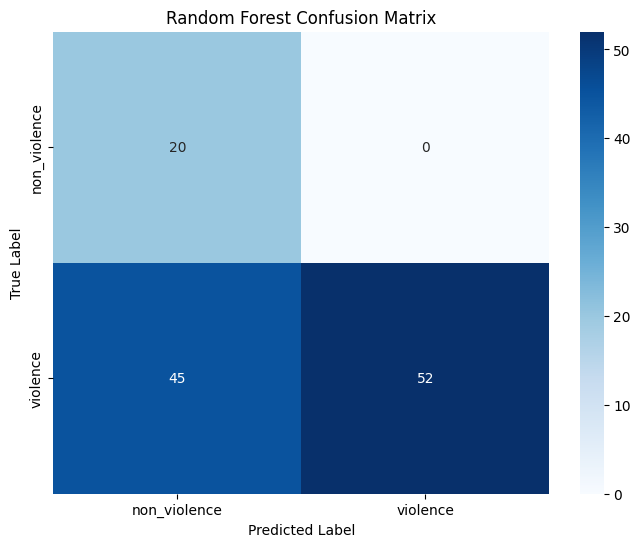

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES,
            yticklabels=CLASSES)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np

n_estimators_range = [50, 100, 200, 300, 400, 500]

train_acc, val_acc = [], []
train_loss, val_loss = [], []

rf_curve = RandomForestClassifier(
    n_estimators=0,  # start from 0
    warm_start=True,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

for n in n_estimators_range:
    rf_curve.n_estimators = n
    rf_curve.fit(X_train_features, y_train_aug)

    train_pred = rf_curve.predict(X_train_features)
    val_pred = rf_curve.predict(X_val_features)

    train_proba = rf_curve.predict_proba(X_train_features)
    val_proba = rf_curve.predict_proba(X_val_features)

    train_acc.append(accuracy_score(y_train_aug, train_pred))
    val_acc.append(accuracy_score(y_val, val_pred))

    train_loss.append(log_loss(y_train_aug, train_proba))
    val_loss.append(log_loss(y_val, val_proba))

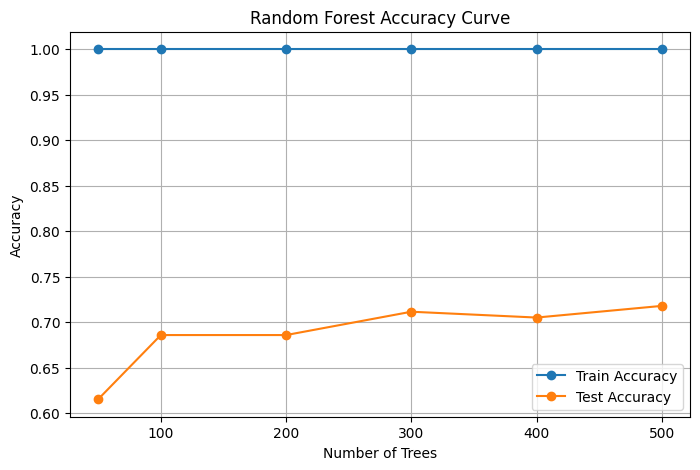

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, train_acc, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, val_acc, marker='o', label='Test Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()


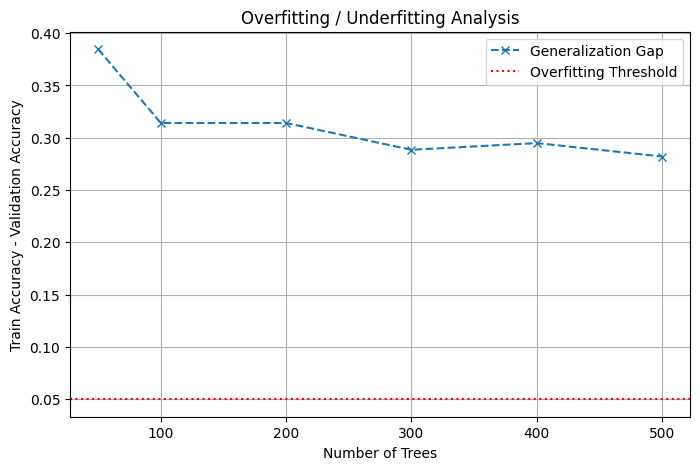

In [ ]:
gap = np.array(train_acc) - np.array(val_acc)

plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, gap, marker='x', linestyle='--', label='Generalization Gap')
plt.axhline(0.05, linestyle=':', color='red', label='Overfitting Threshold')
plt.xlabel('Number of Trees')
plt.ylabel('Train Accuracy - Validation Accuracy')
plt.title('Overfitting / Underfitting Analysis')
plt.legend()
plt.grid(True)
plt.show()


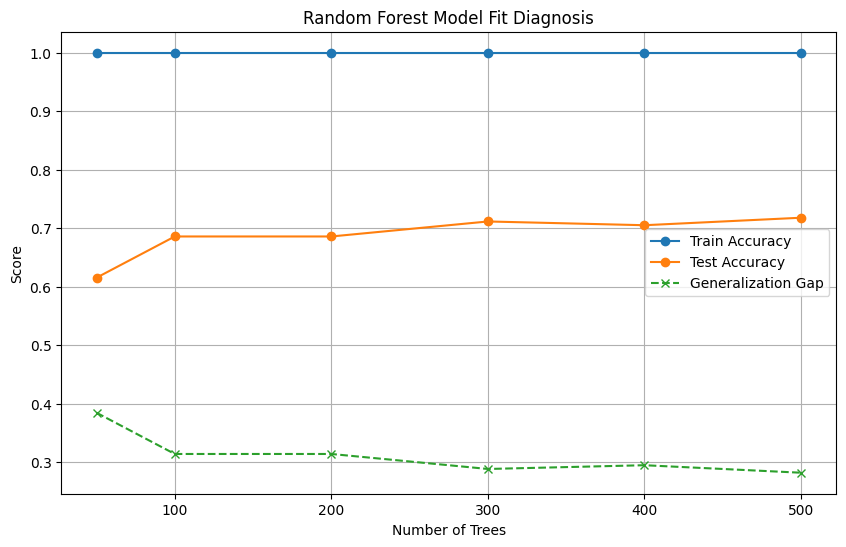

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(n_estimators_range, train_acc, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, val_acc, marker='o', label='Test Accuracy')
plt.plot(n_estimators_range, gap, marker='x', linestyle='--', label='Generalization Gap')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Random Forest Model Fit Diagnosis')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

from google.colab import files
import zipfile
import os

uploaded = files.upload()
zip_name = 'VIOLENCE VS NON_VIOLENCE.zip'
extract_path = 'dataset'

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path))

Saving VIOLENCE VS NON_VIOLENCE.zip to VIOLENCE VS NON_VIOLENCE (3).zip
['VIOLENCE VS NON_VIOLENCE']


In [ ]:
import glob
import os

DATA_DIR = 'dataset/VIOLENCE VS NON_VIOLENCE'
CLASSES = sorted(os.listdir(os.path.join(DATA_DIR, 'train')))
print("Classes:", CLASSES)

def get_image_paths_labels(split):
    X_paths, y_labels = [], []
    for label, cls in enumerate(CLASSES):
        folder = os.path.join(DATA_DIR, split, cls)
        for img_path in glob.glob(os.path.join(folder, '*')):
            X_paths.append(img_path)
            y_labels.append(label)
    return X_paths, y_labels

X_train_paths, y_train = get_image_paths_labels('train')
X_val_paths, y_val = get_image_paths_labels('val')
X_test_paths, y_test = get_image_paths_labels('test')

print(f"Train: {len(X_train_paths)}, Val: {len(X_val_paths)}, Test: {len(X_test_paths)}")

Classes: ['non_violence', 'violence']
Train: 700, Val: 156, Test: 117


In [ ]:
import cv2
import numpy as np
from skimage.feature import hog

def extract_features_with_labels(img_paths, labels):
    features, new_labels = [], []

    for path, label in zip(img_paths, labels):
        img = cv2.imread(path)
        img = cv2.resize(img, (64, 64))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)

        hist = cv2.calcHist([img], [0, 1, 2], None,
                            [8, 8, 8],
                            [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        features.append(np.hstack([hog_feat, hist]))
        new_labels.append(label)

        # Horizontal flip augmentation
        img_flip = cv2.flip(img, 1)
        gray_flip = cv2.cvtColor(img_flip, cv2.COLOR_BGR2GRAY)
        hog_flip = hog(gray_flip, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)

        hist_flip = cv2.calcHist([img_flip], [0, 1, 2], None,
                                 [8, 8, 8],
                                 [0, 256, 0, 256, 0, 256])
        hist_flip = cv2.normalize(hist_flip, hist_flip).flatten()

        features.append(np.hstack([hog_flip, hist_flip]))
        new_labels.append(label)

    return np.array(features), np.array(new_labels)

def extract_features(img_paths):
    features = []
    for path in img_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (64, 64))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)

        hist = cv2.calcHist([img], [0, 1, 2], None,
                            [8, 8, 8],
                            [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        features.append(np.hstack([hog_feat, hist]))

    return np.array(features)

In [ ]:
X_train_features, y_train_aug = extract_features_with_labels(
    X_train_paths, y_train)

X_val_features = extract_features(X_val_paths)
X_test_features = extract_features(X_test_paths)

print("Feature Shapes:")
print("Train:", X_train_features.shape)
print("Val:", X_val_features.shape)
print("Test:", X_test_features.shape)

Feature Shapes:
Train: (1400, 2276)
Val: (156, 2276)
Test: (117, 2276)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_features, y_train_aug)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=4,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
val_pred = rf.predict(X_val_features)
print("Train Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred, target_names=CLASSES))

test_pred = rf.predict(X_test_features)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred, target_names=CLASSES))


Train Accuracy: 0.717948717948718
              precision    recall  f1-score   support

non_violence       0.66      0.90      0.76        78
    violence       0.84      0.54      0.66        78

    accuracy                           0.72       156
   macro avg       0.75      0.72      0.71       156
weighted avg       0.75      0.72      0.71       156

Test Accuracy: 0.6153846153846154
              precision    recall  f1-score   support

non_violence       0.31      1.00      0.47        20
    violence       1.00      0.54      0.70        97

    accuracy                           0.62       117
   macro avg       0.65      0.77      0.58       117
weighted avg       0.88      0.62      0.66       117



In [ ]:
val_pred = rf.predict(X_val_features)
print("train Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred, target_names=CLASSES))

test_pred = rf.predict(X_test_features)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred, target_names=CLASSES))

train Accuracy: 0.717948717948718
              precision    recall  f1-score   support

non_violence       0.66      0.90      0.76        78
    violence       0.84      0.54      0.66        78

    accuracy                           0.72       156
   macro avg       0.75      0.72      0.71       156
weighted avg       0.75      0.72      0.71       156

Test Accuracy: 0.6153846153846154
              precision    recall  f1-score   support

non_violence       0.31      1.00      0.47        20
    violence       1.00      0.54      0.70        97

    accuracy                           0.62       117
   macro avg       0.65      0.77      0.58       117
weighted avg       0.88      0.62      0.66       117



In [ ]:
pred_probs = rf.predict_proba(X_test_features)[:, 1]

pred_labels = []
for prob in pred_probs.flatten():
    if prob > 0.5:
        pred_labels.append("VIOLENCE")
    else:
        pred_labels.append("NON VIOLENCE")

import pandas as pd

filenames = X_test_paths

results = pd.DataFrame({
    'filename': filenames,
    'prediction': pred_labels
})

results.to_csv("random_forest_test_predictions.csv", index=False)
print("Predictions saved!")

for i in range(5):
    print(f"{filenames[i]} --> {pred_labels[i]}")

Predictions saved!
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (440).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (444).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (407).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (299).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (220).jpg --> NON VIOLENCE


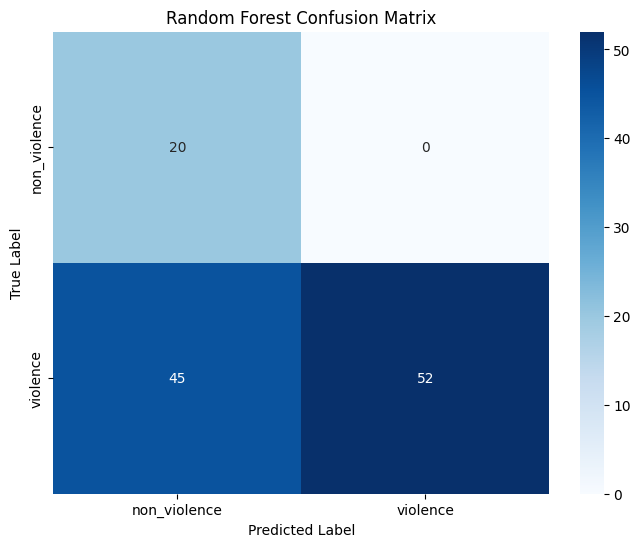

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES,
            yticklabels=CLASSES)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np

n_estimators_range = [50, 100, 200, 300, 400, 500]

train_acc, val_acc = [], []
train_loss, val_loss = [], []

rf_curve = RandomForestClassifier(
    n_estimators=0,  # start from 0
    warm_start=True,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

for n in n_estimators_range:
    rf_curve.n_estimators = n
    rf_curve.fit(X_train_features, y_train_aug)

    train_pred = rf_curve.predict(X_train_features)
    val_pred = rf_curve.predict(X_val_features)

    train_proba = rf_curve.predict_proba(X_train_features)
    val_proba = rf_curve.predict_proba(X_val_features)

    train_acc.append(accuracy_score(y_train_aug, train_pred))
    val_acc.append(accuracy_score(y_val, val_pred))

    train_loss.append(log_loss(y_train_aug, train_proba))
    val_loss.append(log_loss(y_val, val_proba))

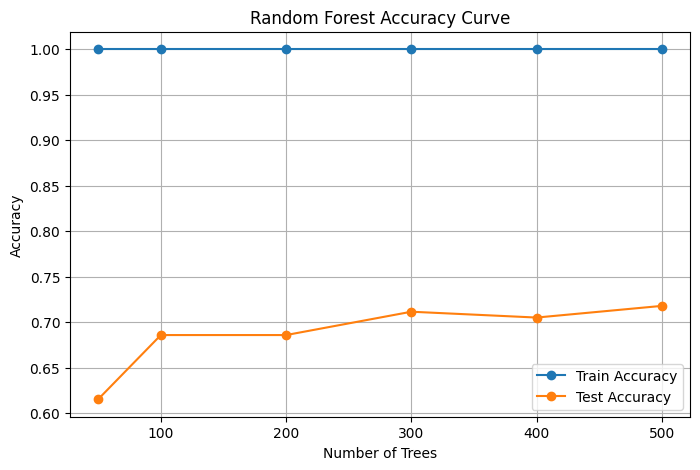

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, train_acc, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, val_acc, marker='o', label='Test Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()


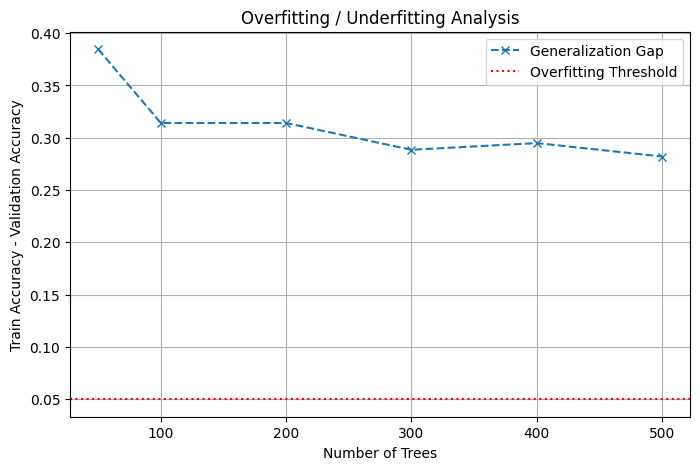

In [ ]:
gap = np.array(train_acc) - np.array(val_acc)

plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, gap, marker='x', linestyle='--', label='Generalization Gap')
plt.axhline(0.05, linestyle=':', color='red', label='Overfitting Threshold')
plt.xlabel('Number of Trees')
plt.ylabel('Train Accuracy - Validation Accuracy')
plt.title('Overfitting / Underfitting Analysis')
plt.legend()
plt.grid(True)
plt.show()


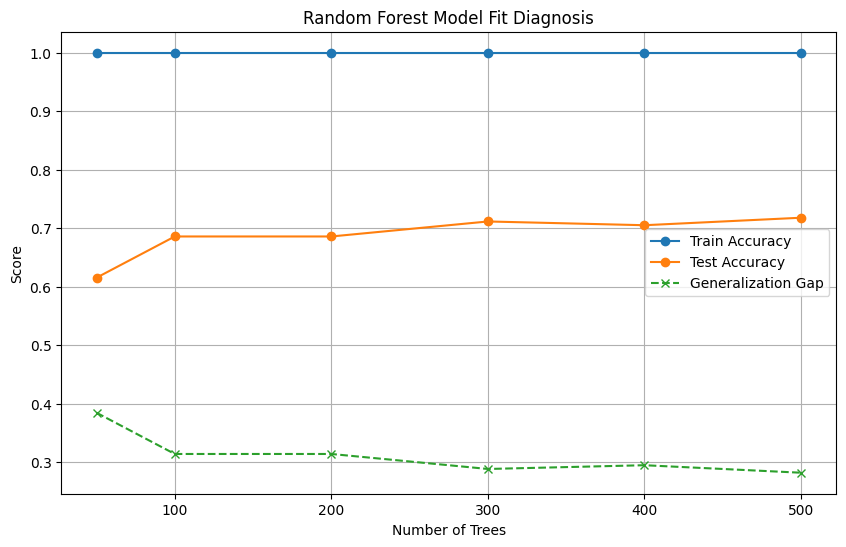

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(n_estimators_range, train_acc, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, val_acc, marker='o', label='Test Accuracy')
plt.plot(n_estimators_range, gap, marker='x', linestyle='--', label='Generalization Gap')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Random Forest Model Fit Diagnosis')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
import joblib

# Save the trained Random Forest model to a file
model_filename = "random_forest_model.pkl"
joblib.dump(rf, model_filename)

print(f"Random Forest model saved as '{model_filename}'")

# Optional: Download the model to your local machine
from google.colab import files
files.download(model_filename)


Random Forest model saved as 'random_forest_model.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>